In [1]:
"""
Plots bar charts for motif count changes
"""
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath('../'))

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

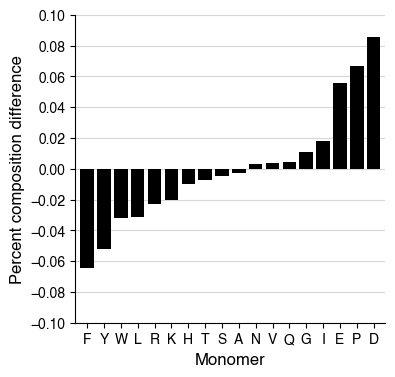

In [2]:
# Monomers

s1_mon_df = pd.read_csv(f'../seq/monomer/S1_monomer_freq.txt').set_index('Monomer')
s4_mon_df = pd.read_csv(f'../seq/monomer/S4_monomer_freq.txt').set_index('Monomer')
monomer_change = s4_mon_df - s1_mon_df
monomer_change = monomer_change.sort_values('Frequency')

AMINO_ACIDS = monomer_change.index
CLEAVAGE_AAs = ['F', 'L', 'W', 'Y']

fig = plt.figure(figsize=(4, 4))
plt.bar(monomer_change.index, monomer_change['Frequency'], color='black', zorder=2)
plt.ylabel('Percent composition difference', fontsize=12)
plt.xlabel('Monomer', fontsize=12)
plt.yticks([-0.1 + 0.02*i for i in range(11)])
plt.xlim(-0.7,len(monomer_change)-.3)
plt.grid(True, axis='y', zorder=1, alpha=0.5)
plt.savefig('../figs/monomer_motif_change.svg', format='svg', dpi=300)
plt.savefig('../figs/monomer_motif_change.png', format='png', dpi=300)
plt.show()

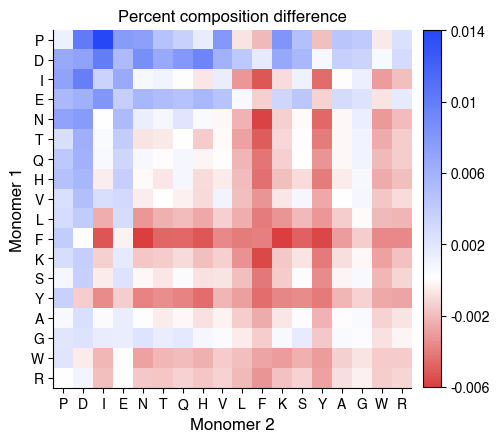

In [3]:
# Pairs
s1_pairs_df = pd.read_csv('../seq/pair/S1_pair_freq.txt', na_filter=False).set_index('Pair')
s4_pairs_df = pd.read_csv('../seq/pair/S4_pair_freq.txt', na_filter=False).set_index('Pair')
pairs_df = s4_pairs_df - s1_pairs_df

# Normalize frequencies to 0-1 for cmapping
max_freq = pairs_df['Frequency'].max()
min_freq = pairs_df['Frequency'].min()
pairs_df['Frequency'] = (pairs_df['Frequency'] - min_freq) / (max_freq - min_freq)
midpoint = -min_freq / (max_freq - min_freq)

# Preserve axes order for approx. grouping of change
pairs_df = pairs_df.sort_values('Frequency', ascending=False)
axes_order = [s[0] for s in pairs_df.index]
axes_order = list(dict.fromkeys(axes_order))
pairs_df = pairs_df.reset_index()

# Reshape df
pairs_df[['p1', 'p2']] = pairs_df['Pair'].str.split('', expand=True)[[1, 2]]
pairs_df = pairs_df[['p1', 'p2', 'Frequency']].pivot(index='p1', columns='p2')['Frequency']
pairs_df = pairs_df.reindex(axes_order)[axes_order]


# Plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
gradient = LinearSegmentedColormap.from_list('gradient', (
                                            (0, (0.855, 0.247, 0.247)),
                                            (midpoint, (1.000, 1.000, 1.000)),
                                            (1, (0.145, 0.286, 0.961))))
heatmap = ax.imshow(pairs_df.to_numpy(), cmap=gradient)
cbar = plt.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.03)

# Change colorbar ticks back to %change
locs = [round(i, 3) for i in list(np.arange(0, 1.2, 0.2))]
labels = [round(i, 3) for i in list(np.arange(min_freq, max_freq + 0.004, 0.004))]
cbar.set_ticks(locs)
cbar.set_ticklabels(labels)
                    
# Plot and save
ax.set_title('Percent composition difference', size=12)
ax.set_xticks(range(len(pairs_df)))
ax.set_yticks(range(len(pairs_df)))
ax.set_xticklabels(pairs_df.columns)
ax.set_yticklabels(pairs_df.index)
plt.ylabel('Monomer 1', fontsize=12)
plt.xlabel('Monomer 2', fontsize=12)
plt.savefig('../figs/pair_motif_change.svg', format='svg', dpi=300)
plt.savefig('../figs/pair_motif_change.png', format='png', dpi=300)
plt.show()

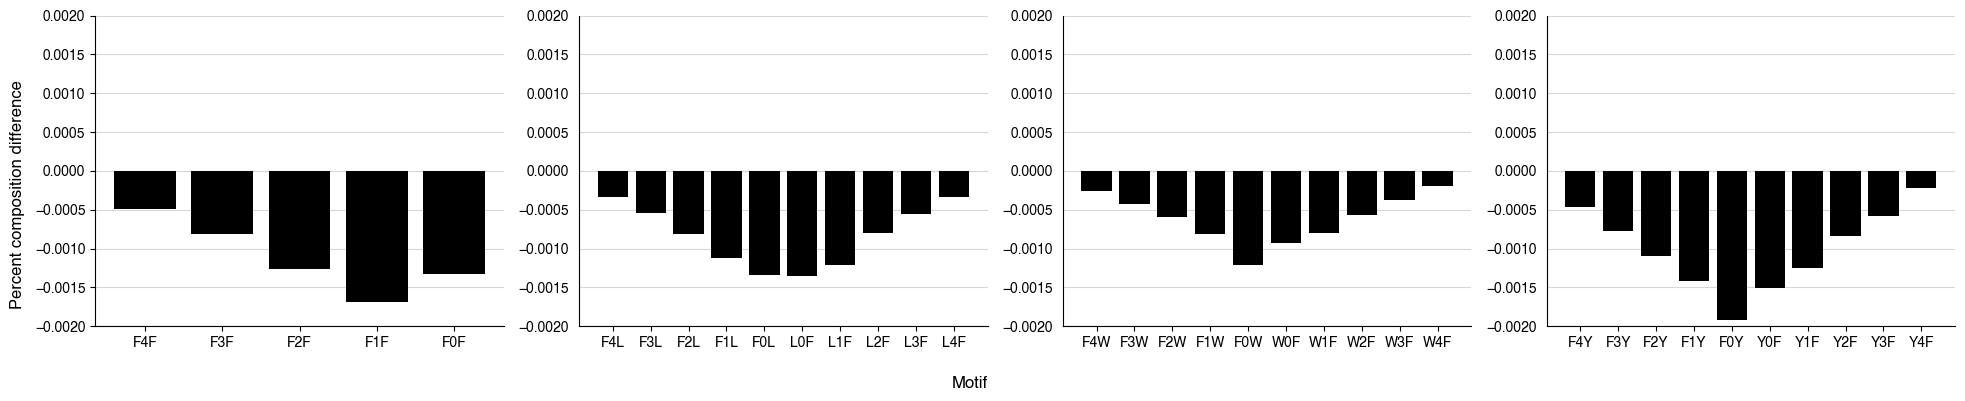

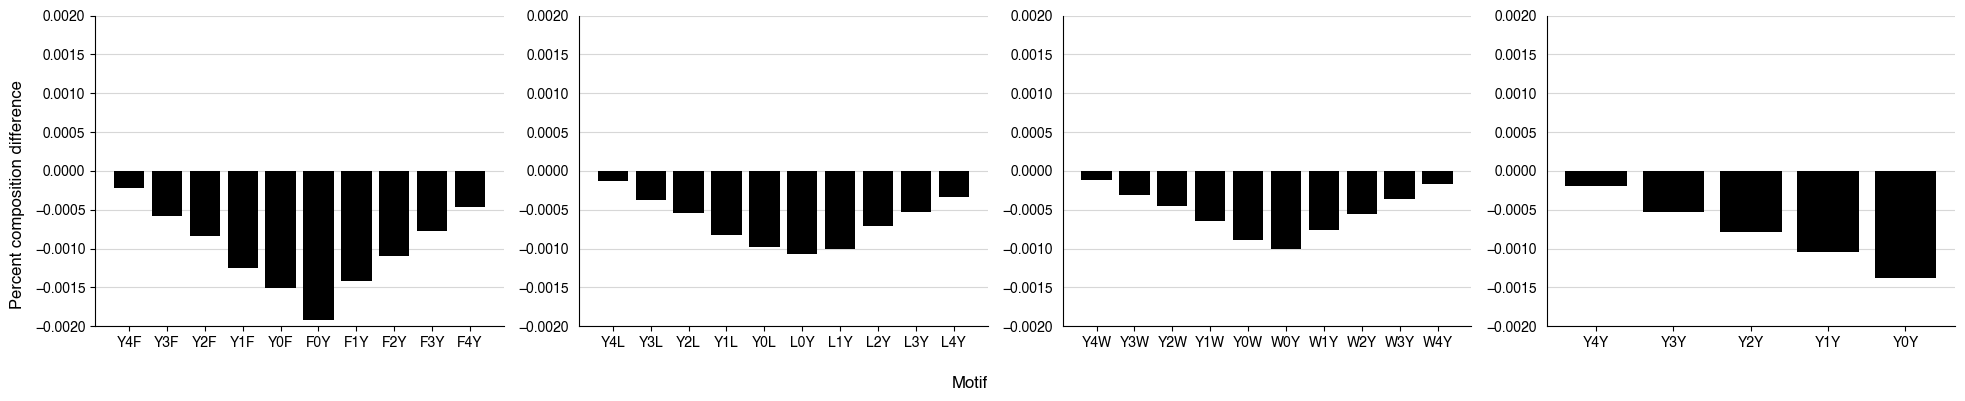

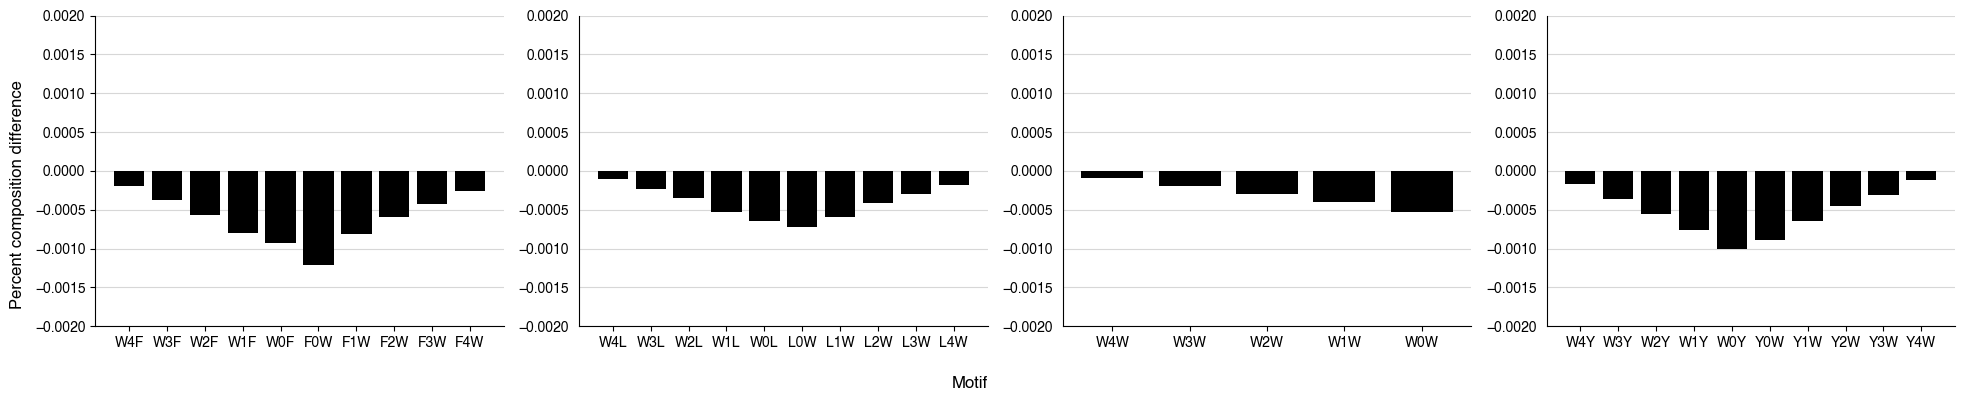

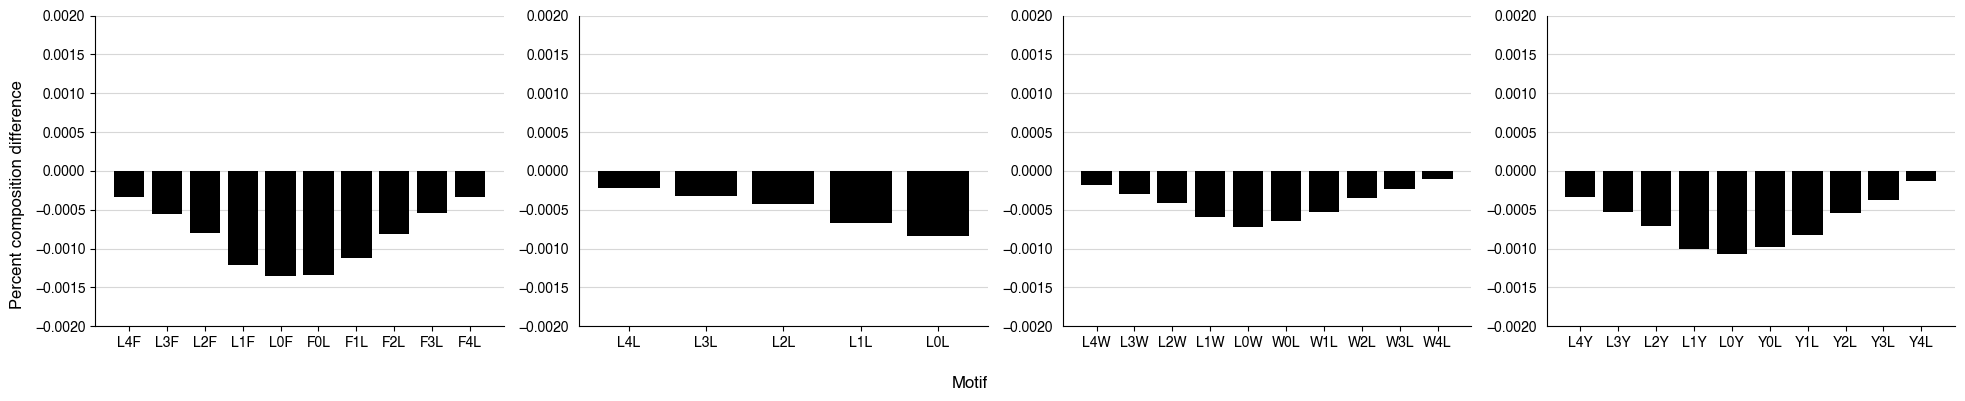

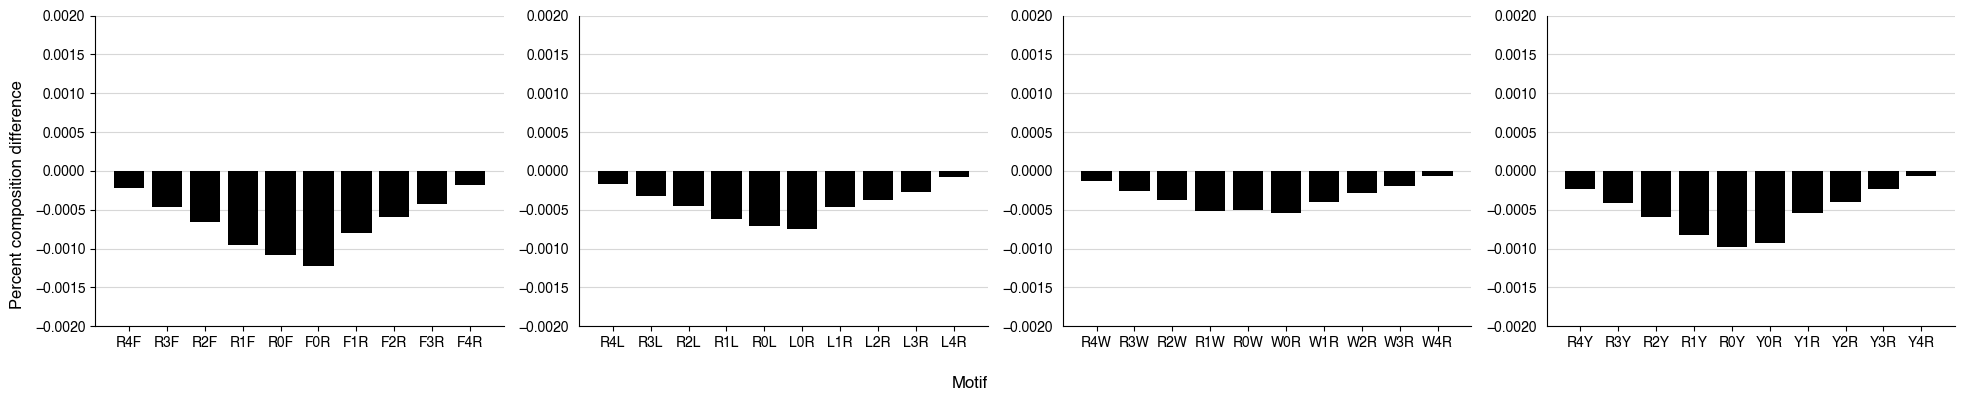

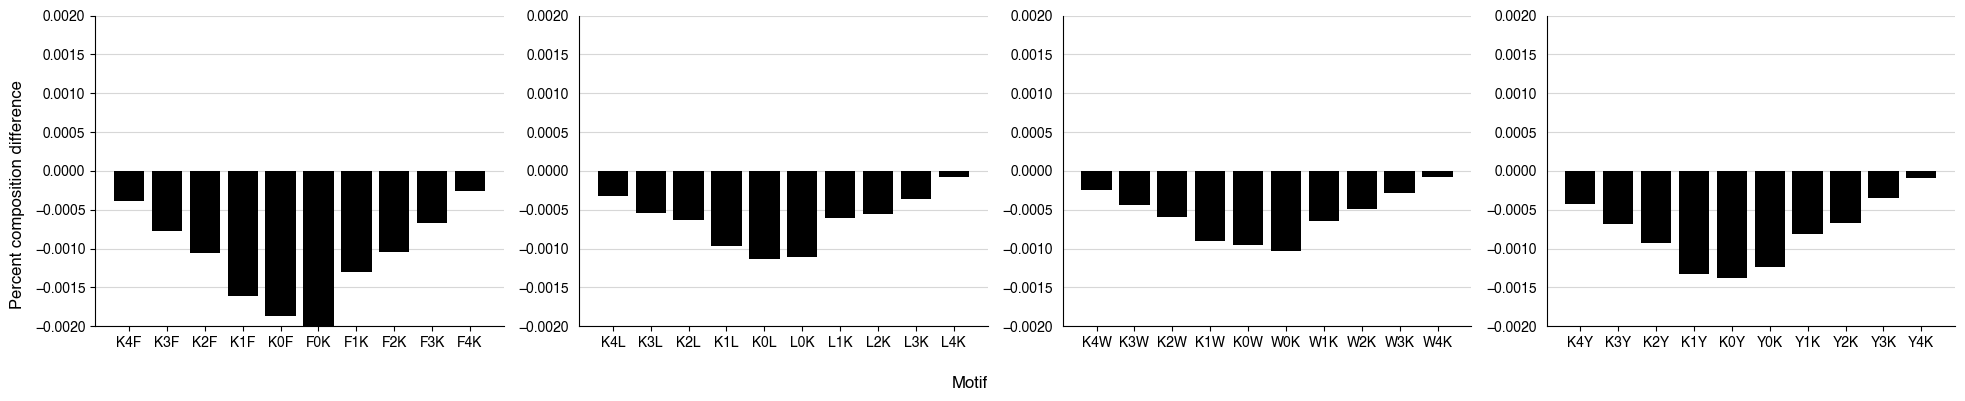

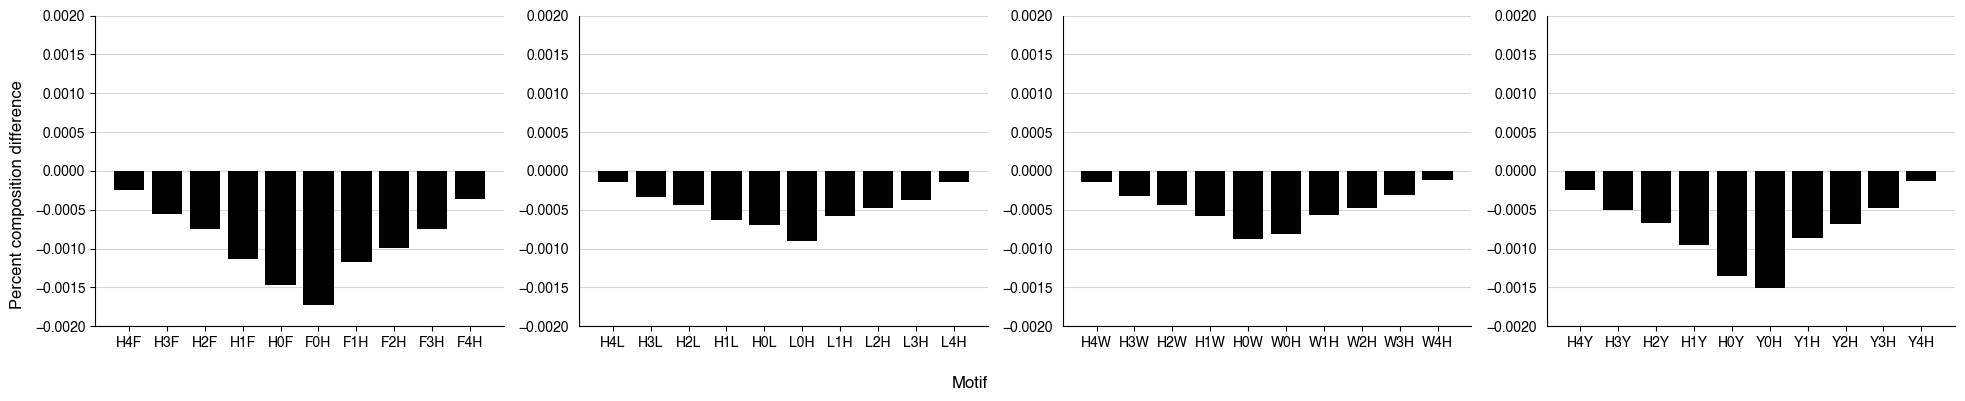

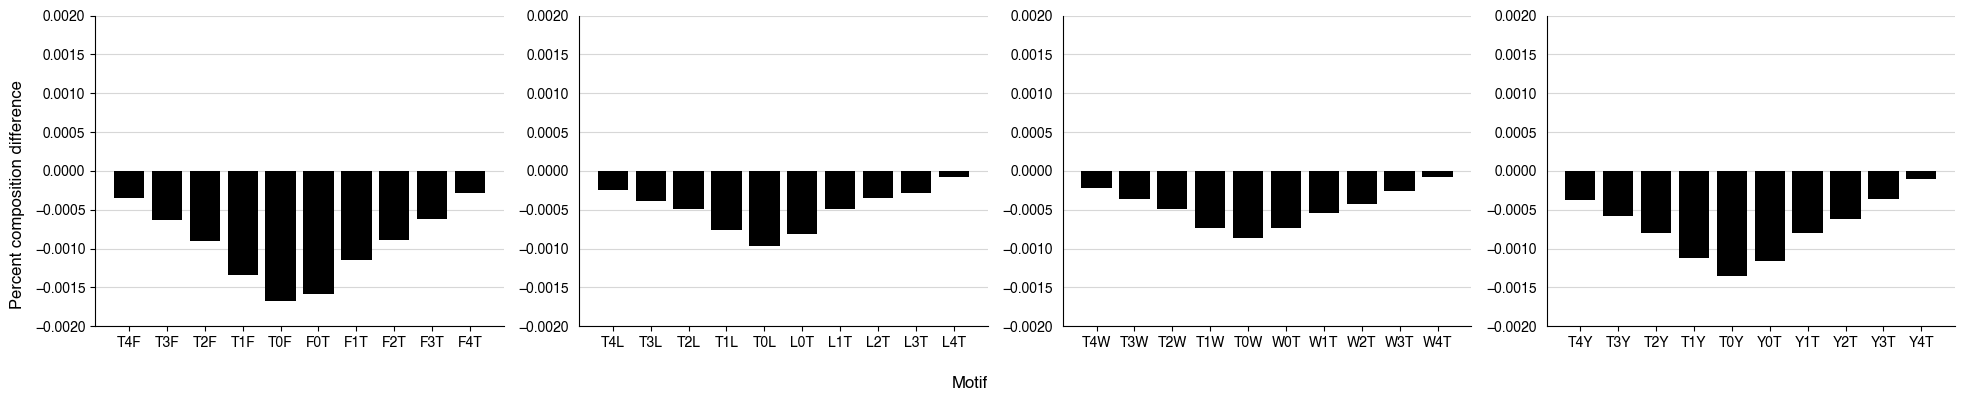

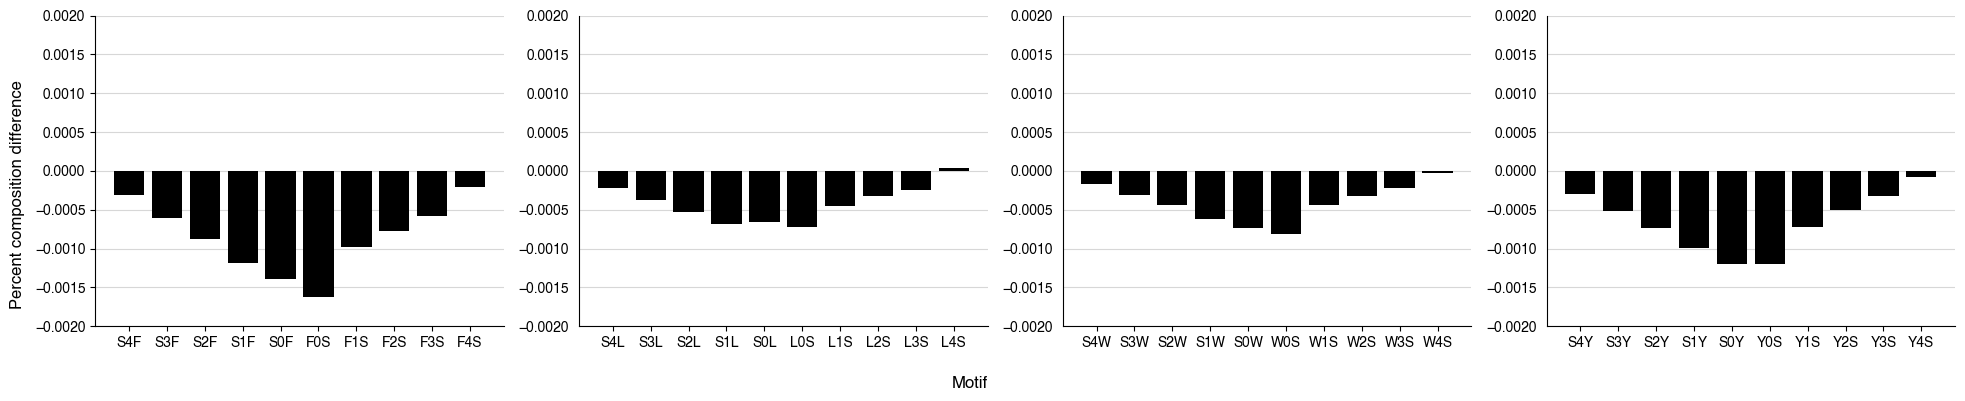

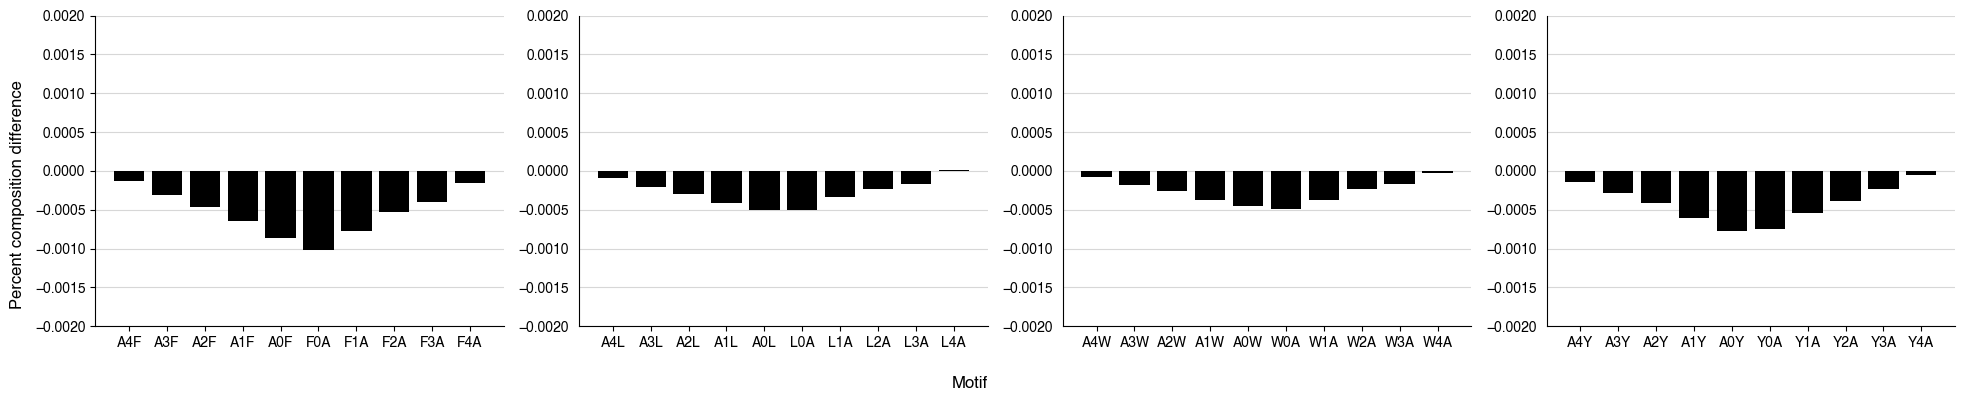

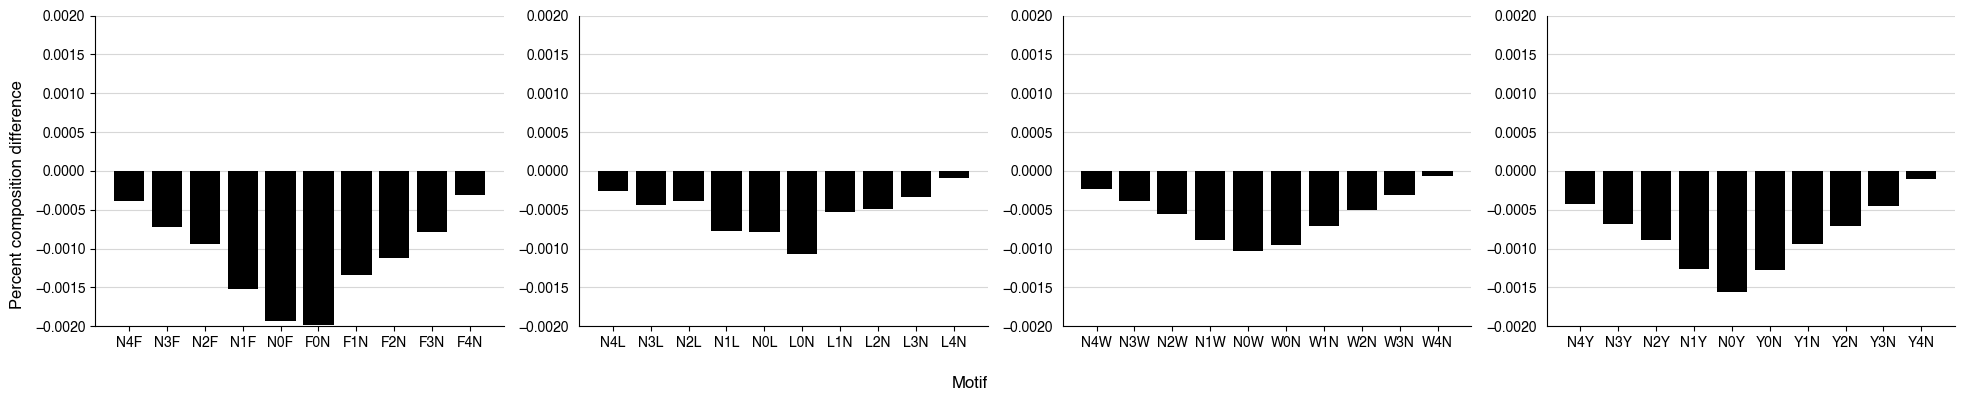

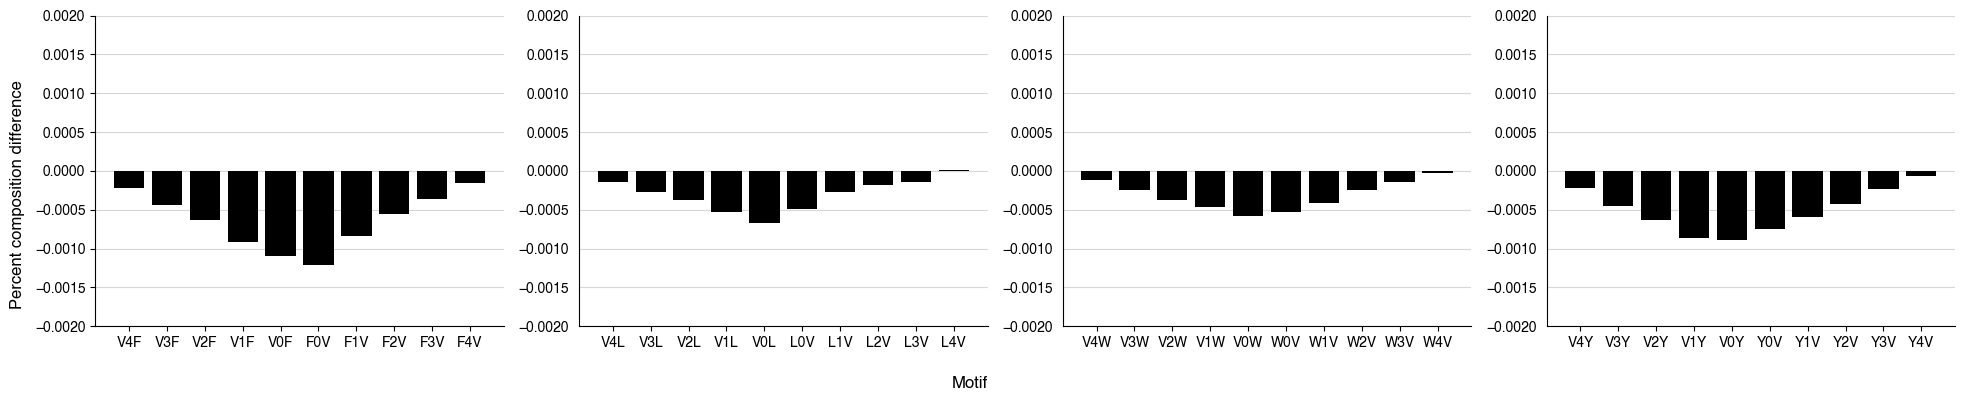

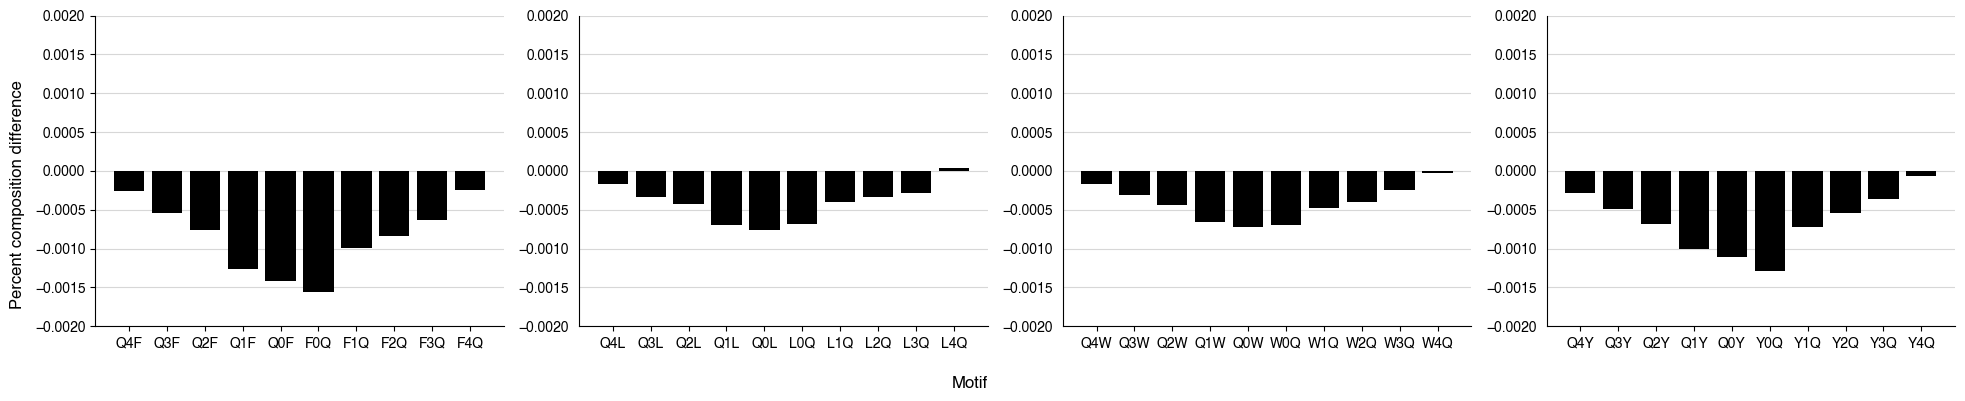

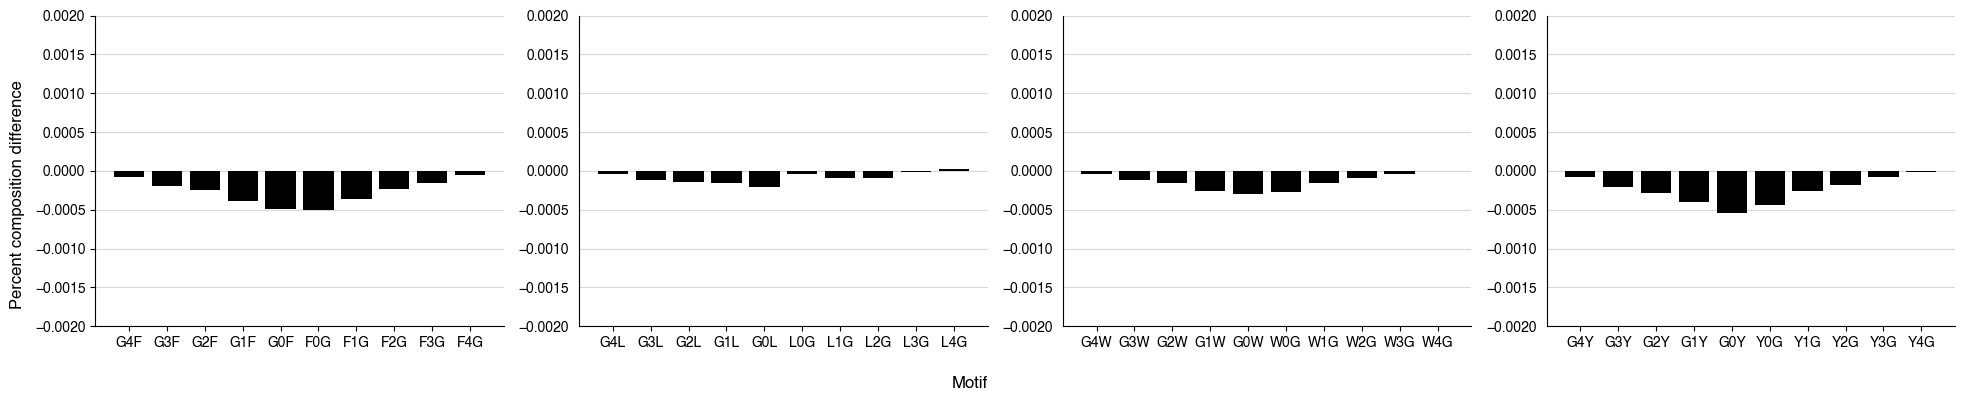

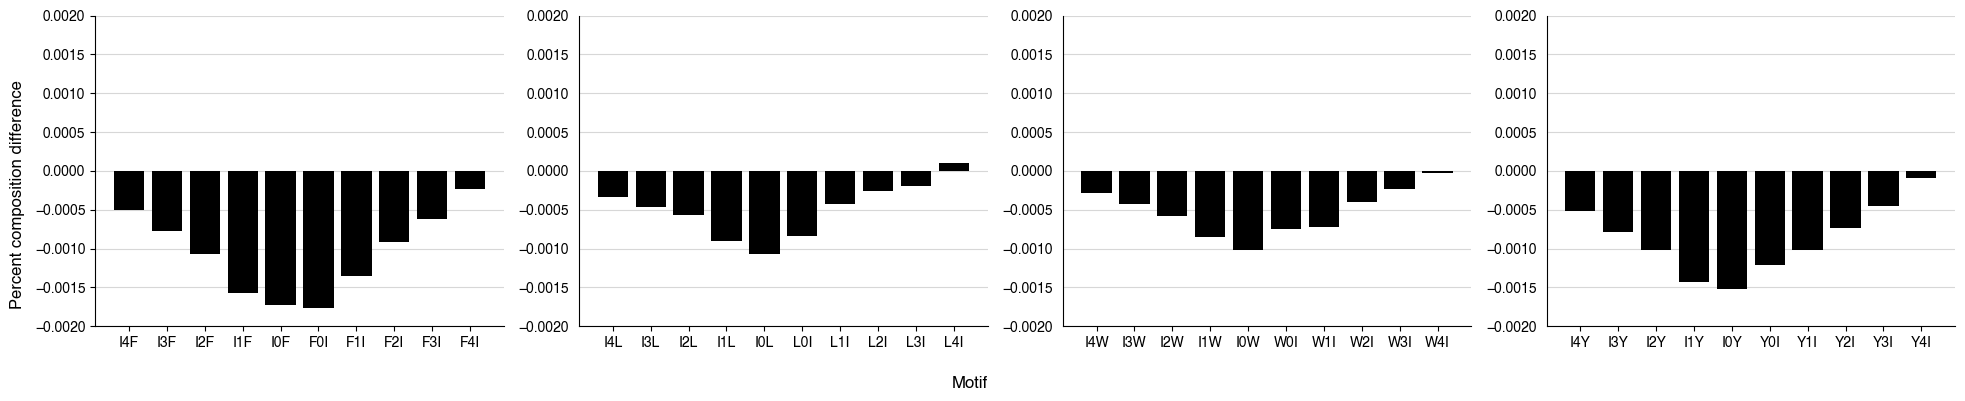

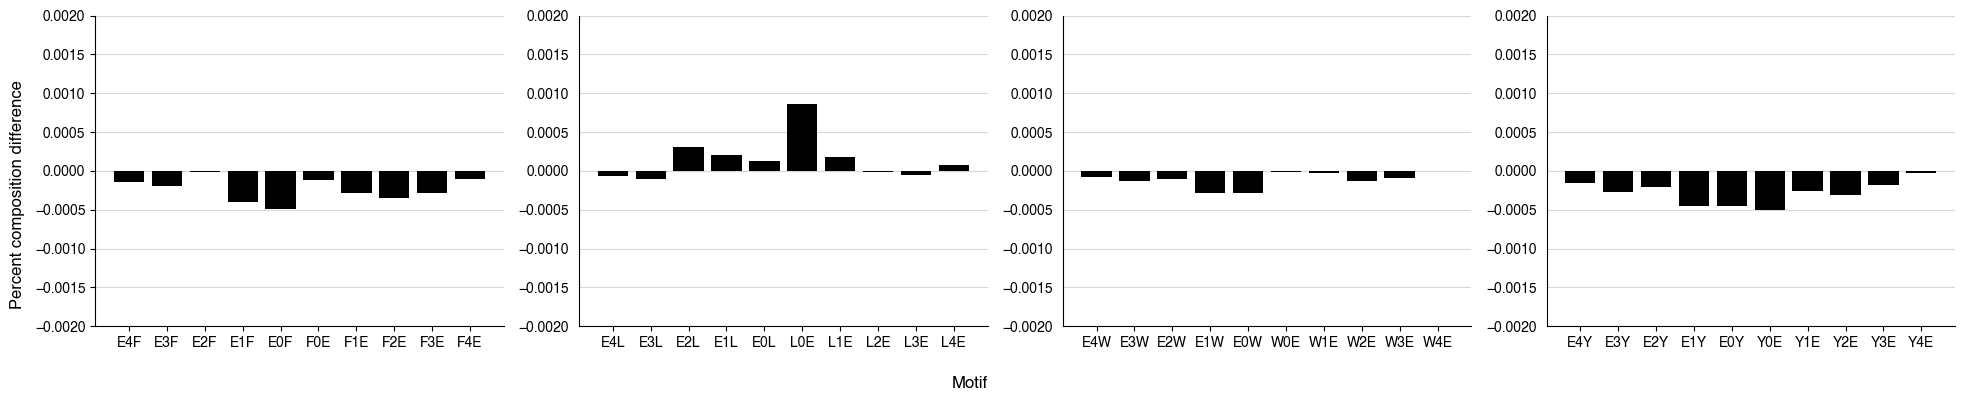

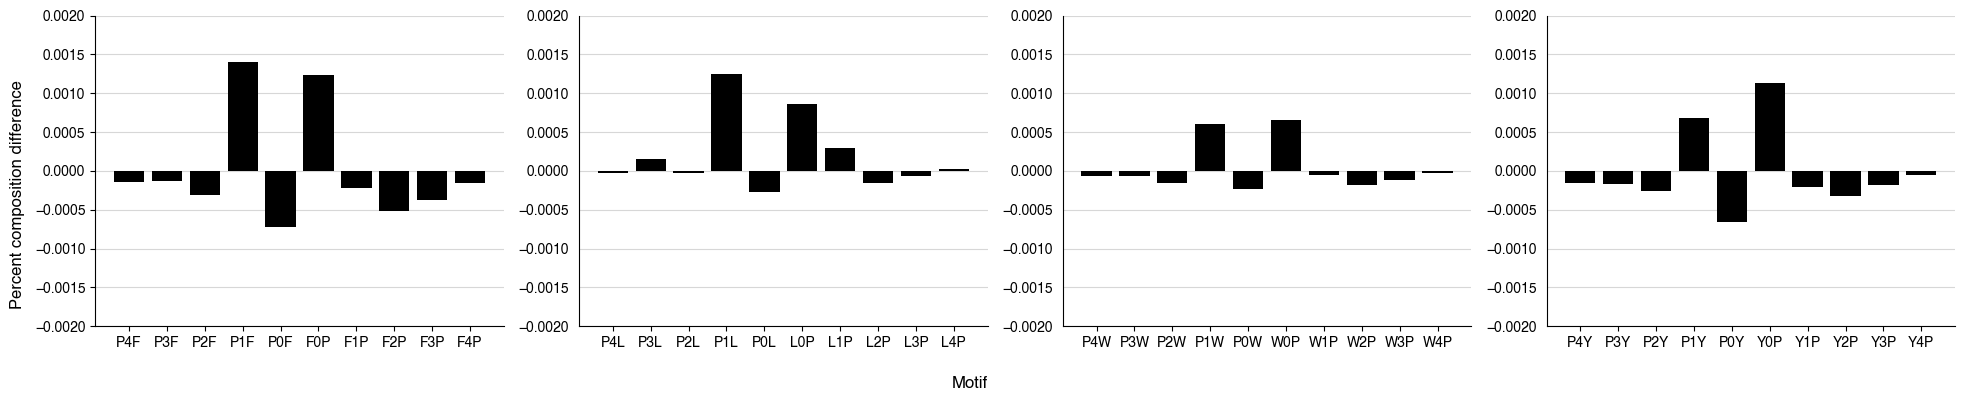

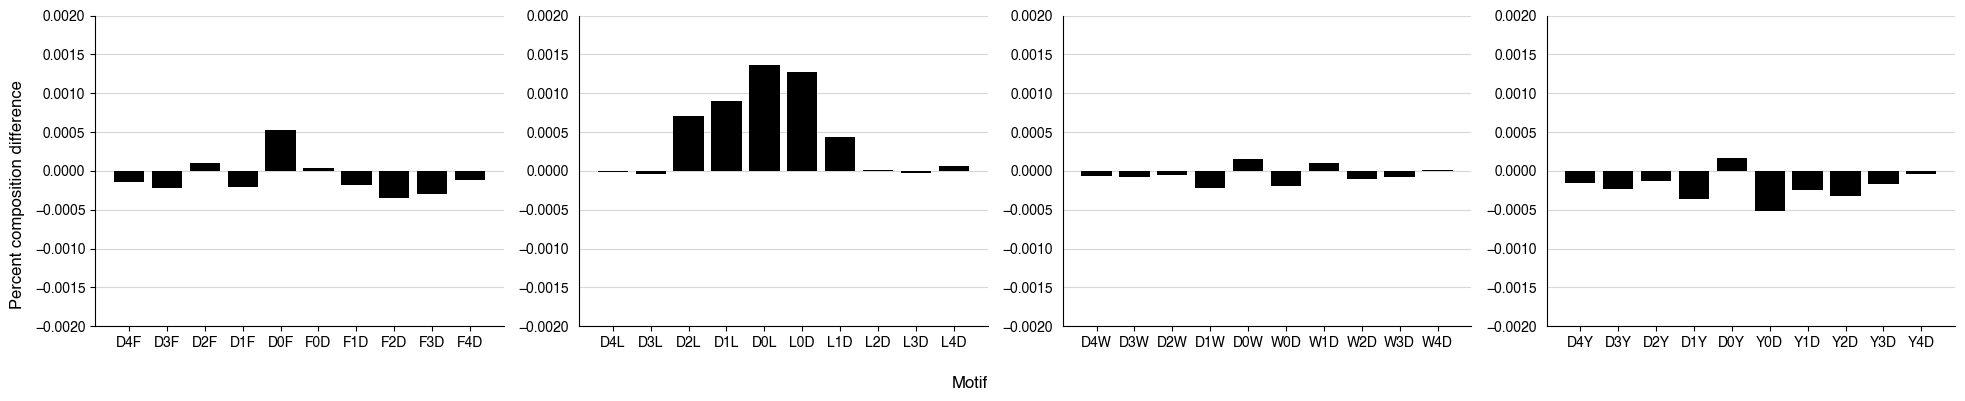

In [7]:
# N-distance
s1_motif_df = pd.read_csv('../seq/n_dist/S1_ndist_freq.txt', na_filter=False).set_index('Motif')
s4_motif_df = pd.read_csv('../seq/n_dist/S4_ndist_freq.txt', na_filter=False).set_index('Motif')
motif_df = s4_motif_df - s1_motif_df
motif_df = motif_df.reset_index()

motif_df['N_res'] = motif_df['Motif'].str.slice(0, 1)
motif_df['C_res'] = motif_df['Motif'].str.slice(-1)
motif_df['Pair'] = motif_df['N_res'] + motif_df['C_res']
motif_df['distance'] = motif_df['Motif'].str.slice(1, 2)

for protector in AMINO_ACIDS:
    count = 1
    fig = plt.figure(figsize=(20, 4))
    fig.supxlabel('Motif')
    fig.supylabel('Percent composition difference')
    for cleavage_res in CLEAVAGE_AAs:
        protector_df_1 = (motif_df[(motif_df['N_res'] == protector) & (motif_df['C_res'] == cleavage_res)]).sort_values('distance', ascending=False)
        protector_df_2 = (motif_df[(motif_df['C_res'] == protector) & (motif_df['N_res'] == cleavage_res)]).sort_values('distance')
        protector_df = pd.concat([protector_df_1, protector_df_2])
        
        plt.subplot(1, 4, count)    
        plt.bar(protector_df['Motif'], protector_df['Frequency'], color='black', zorder=2)
#         plt.ylabel('Percent composition difference', fontsize=12)
#         plt.xlabel('Monomer', fontsize=12)
        if count != 1:
            plt.tick_params(left=False)
        plt.ylim(-0.002, 0.002)
        plt.grid(True, axis='y', zorder=1, alpha=0.5)
        count += 1

    plt.tight_layout(rect=(0.01,0,1,1))
    plt.savefig(f'../figs/n_dist/{protector}_change.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.savefig(f'../figs/n_dist/{protector}_change.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
        